# Multi-Class Brain Tumor Classification with MRI Scans
### Course: Machine Learning
### Author: Mohammad Ahadzadeh
#### Date: June 27, 2025

## Introduction & Project Setup

### Project Goal
The primary goal of this project is to develop and evaluate a suite of machine learning and deep learning models for the multi-class classification of brain tumors from MRI scans.

### Dataset Description
This project utilizes the "Brain Tumor MRI Dataset" from Kaggle. It combines three different data sources to create a comprehensive collection of 7,023 MRI images. 

The images are categorized into four distinct classes:

- Glioma: A common type of tumor that originates in the glial cells that surround and support neurons in the brain.

- Meningioma: A tumor that arises from the membranes that surround your brain and spinal cord.

- Pituitary Tumor: An abnormal growth in the pituitary gland, a small gland at the base of the brain that regulates hormones.

- No Tumor

### Environment Setup

#### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import os
from PIL import Image
import time

from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import warnings
warnings.filterwarnings('ignore')


#### Setting Up the Computation Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Define Configurations Parameters and Paths

In [3]:
TRAIN_DIR = 'Brain Tumor MRI Dataset/Training'
TEST_DIR = 'Brain Tumor MRI Dataset/Testing'

BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 30
NUM_CLASSES = 4

IMG_HEIGHT = 224
IMG_WIDTH = 224

## Data Preparation & Exploratory Data Analysis

### Loading the Dataset

In [4]:
def create_dataframe(directory):
    paths = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    paths.append(os.path.join(label_dir, image_file))
                    labels.append(label)
    
    return pd.DataFrame({'path': paths, 'label': labels})

train_df = create_dataframe(TRAIN_DIR)
test_df = create_dataframe(TEST_DIR)

print("Training Data:")
print(train_df.head())
print(f"\nTotal training images: {len(train_df)}")
print("\nTesting Data:")
print(test_df.head())
print(f"Total testing images: {len(test_df)}")

Training Data:
                                                path   label
0  Brain Tumor MRI Dataset/Training\glioma\Tr-glT...  glioma
1  Brain Tumor MRI Dataset/Training\glioma\Tr-glT...  glioma
2  Brain Tumor MRI Dataset/Training\glioma\Tr-glT...  glioma
3  Brain Tumor MRI Dataset/Training\glioma\Tr-glT...  glioma
4  Brain Tumor MRI Dataset/Training\glioma\Tr-glT...  glioma

Total training images: 5712

Testing Data:
                                                path   label
0  Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...  glioma
1  Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...  glioma
2  Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...  glioma
3  Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...  glioma
4  Brain Tumor MRI Dataset/Testing\glioma\Te-glTr...  glioma
Total testing images: 1311


### Exploratory Data Analysis

#### Visualizing Class Distribution

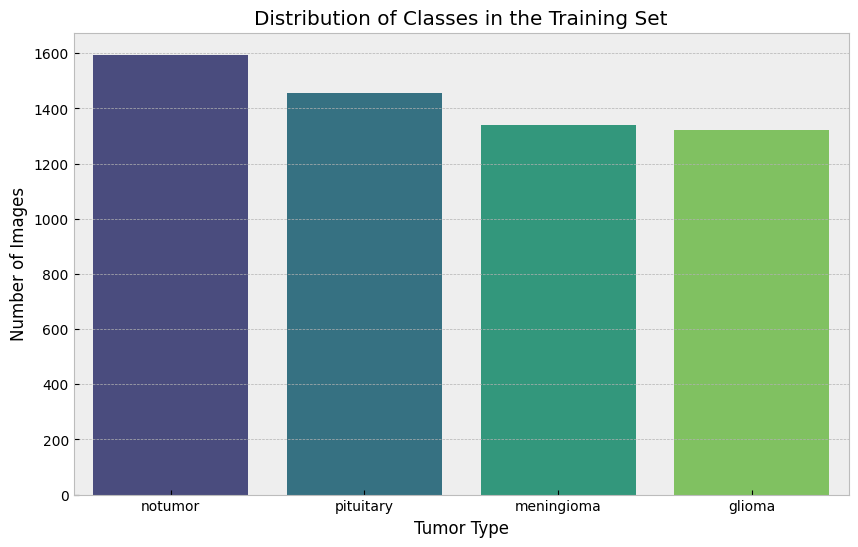

In [51]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_df, order=train_df['label'].value_counts().index, palette='viridis')
plt.title('Distribution of Classes in the Training Set')
plt.xlabel('Tumor Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.show()

#### Visualizing Sample Images

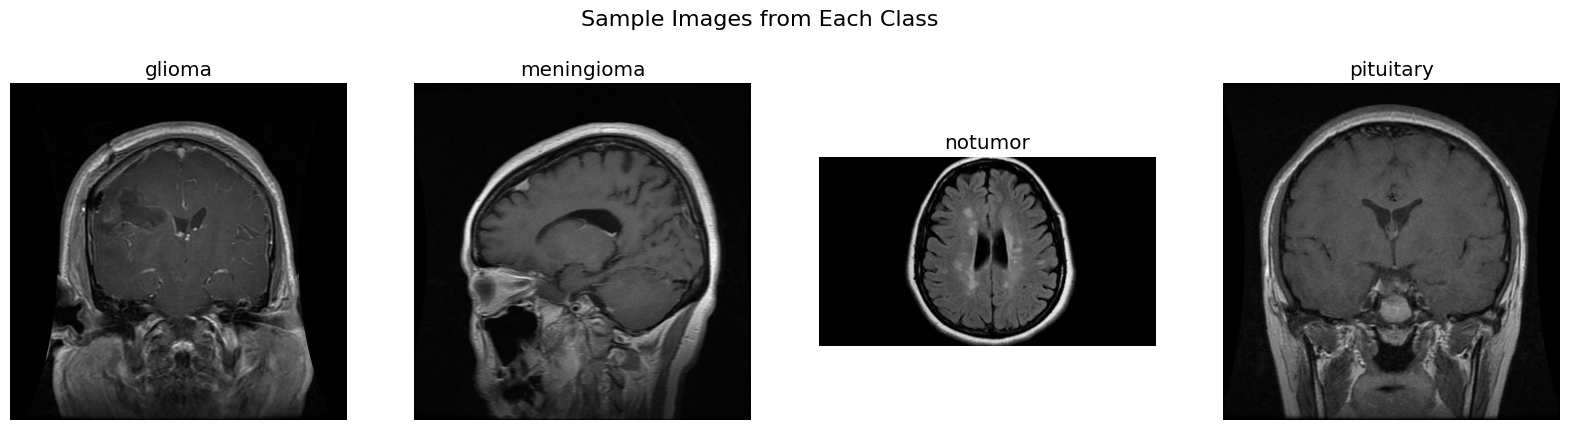

In [6]:
def visualize_samples(df):
    fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(20, 5))
    fig.suptitle('Sample Images from Each Class', fontsize=16)
    
    for i, label in enumerate(df['label'].unique()):
        sample_path = df[df['label'] == label].sample(1).iloc[0]['path']
        img = Image.open(sample_path).convert('RGB')
        ax = axes[i]
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

visualize_samples(train_df)

### Data Preprocessing & Augmentation

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Creating PyTorch Dataset

In [ ]:
all_labels = sorted(train_df['label'].unique())
global_label_map = {label: i for i, label in enumerate(all_labels)}

class BrainTumorDataset(Dataset):
    def __init__(self, df, label_map, transform=None):
        self.df = df
        self.transform = transform
        self.label_map = label_map 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label_str = self.df.iloc[idx]['label']
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        label = self.label_map[label_str]
        
        return image, torch.tensor(label, dtype=torch.long)

### Splitting the Data

In [9]:
train_sub_df, val_df = train_test_split(
    train_df, 
    test_size=0.15, 
    random_state=42, 
    stratify=train_df['label']
)

print(f"Training subset size: {len(train_sub_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training subset size: 4855
Validation set size: 857
Test set size: 1311


### Creating DataLoaders

In [10]:
train_dataset = BrainTumorDataset(train_sub_df, global_label_map, transform=train_transforms)
val_dataset = BrainTumorDataset(val_df, global_label_map, transform=val_test_transforms)
test_dataset = BrainTumorDataset(test_df, global_label_map, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print("\nChecking a batch from the train_loader...")
images, labels = next(iter(train_loader))
print("Successfully fetched a batch!")
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")
print(f"Label batch dtype: {labels.dtype}")


Checking a batch from the train_loader...
Successfully fetched a batch!
Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])
Label batch dtype: torch.int64


## Feature Extraction & Dimensionality Reduction

Classical machine learning models cannot work directly with image pixels. We must first perform feature extraction, which is the process of converting an image into a numerical vector that captures its important characteristics. For this task, we will use the Histogram of Oriented Gradients (HOG) method, which is effective at capturing shape and texture.

### Feature Extraction with HOG

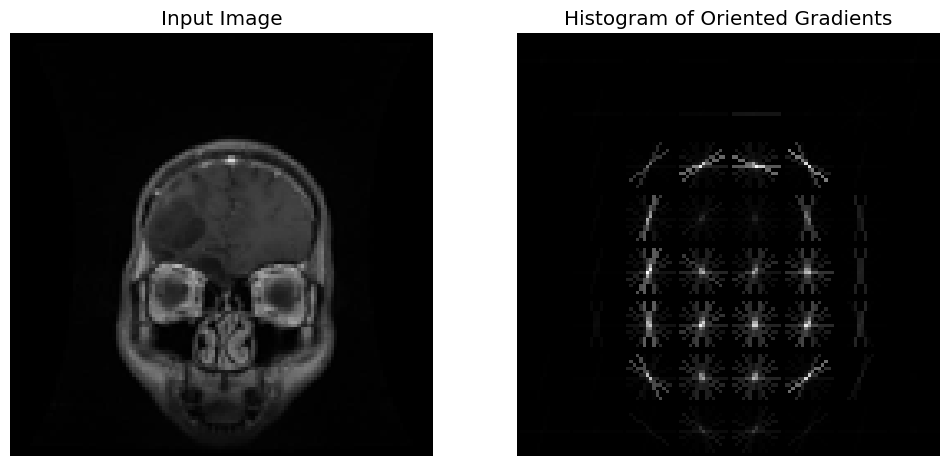

HOG feature vector shape for one image: (1764,)


Extracting Test HOG: 100%|██████████| 1311/1311 [00:04<00:00, 275.44it/s]


Shape of training features: (5712, 1764)
Shape of testing features: (1311, 1764)


In [11]:
def extract_hog_features(img):
    resized_img = img.resize((128, 128))
    gray_img = rgb2gray(np.array(resized_img))
    features = hog(gray_img, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2))
    return features

sample_path = train_df[train_df['label'] == 'glioma'].sample(1).iloc[0]['path']
sample_img = Image.open(sample_path).convert('RGB')
resized_sample_img = sample_img.resize((128, 128))
gray_sample_img = rgb2gray(np.array(resized_sample_img))

features, hog_image = hog(gray_sample_img, pixels_per_cell=(16, 16),
                          cells_per_block=(2, 2), visualize=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(resized_sample_img)
ax1.set_title('Input Image')
ax2.axis('off')
ax2.imshow(hog_image, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

print(f"HOG feature vector shape for one image: {features.shape}")

X_train_hog = np.array([extract_hog_features(Image.open(path).convert('RGB')) for path in tqdm(train_df['path'], desc="Extracting Train HOG")])
X_test_hog = np.array([extract_hog_features(Image.open(path).convert('RGB')) for path in tqdm(test_df['path'], desc="Extracting Test HOG")])

y_train = train_df['label'].values
y_test = test_df['label'].values

print(f"\nShape of training features: {X_train_hog.shape}")
print(f"Shape of testing features: {X_test_hog.shape}")

### Dimensionality Reduction with PCA

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_hog)
X_test_scaled = scaler.transform(X_test_hog)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Original number of features: {X_train_scaled.shape[1]}")
print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")

Original number of features: 1764
Reduced number of features after PCA: 389


## Classical Classification Models

### Model Training and Evaluation

In [13]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=715),
    "Random Forest": RandomForestClassifier(random_state=715),
    "Support Vector Machine": SVC(probability=True, random_state=715) 
}

results = {}

for name, clf in classifiers.items():
    print(f"--- Training {name} ---")
    start_time = time.time()
    
    clf.fit(X_train_pca, y_train)

    y_pred = clf.predict(X_test_pca)
    accuracy = clf.score(X_test_pca, y_test)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    results[name] = accuracy
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))
    print("-" * 30 + "\n")

--- Training Logistic Regression ---
Accuracy: 0.8719
Training Time: 1.47 seconds

Classification Report for Logistic Regression:

              precision    recall  f1-score   support

      glioma       0.82      0.80      0.81       300
  meningioma       0.77      0.76      0.77       306
     notumor       0.96      0.98      0.97       405
   pituitary       0.91      0.90      0.90       300

    accuracy                           0.87      1311
   macro avg       0.86      0.86      0.86      1311
weighted avg       0.87      0.87      0.87      1311

------------------------------

--- Training Linear Discriminant Analysis ---
Accuracy: 0.8055
Training Time: 0.20 seconds

Classification Report for Linear Discriminant Analysis:

              precision    recall  f1-score   support

      glioma       0.84      0.75      0.79       300
  meningioma       0.65      0.56      0.60       306
     notumor       0.89      0.94      0.91       405
   pituitary       0.80      0.93   

  File "c:\Users\Zesyrus\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\Zesyrus\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 556, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Zesyrus\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1038, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
          

Accuracy: 0.7521
Training Time: 0.07 seconds

Classification Report for Naive Bayes:

              precision    recall  f1-score   support

      glioma       0.69      0.67      0.68       300
  meningioma       0.55      0.56      0.55       306
     notumor       0.92      0.86      0.89       405
   pituitary       0.81      0.88      0.84       300

    accuracy                           0.75      1311
   macro avg       0.74      0.74      0.74      1311
weighted avg       0.75      0.75      0.75      1311

------------------------------

--- Training Decision Tree ---
Accuracy: 0.8169
Training Time: 4.29 seconds

Classification Report for Decision Tree:

              precision    recall  f1-score   support

      glioma       0.72      0.68      0.70       300
  meningioma       0.70      0.73      0.71       306
     notumor       0.94      0.96      0.95       405
   pituitary       0.86      0.85      0.85       300

    accuracy                           0.82      1311
  

### Ensemble Classification

In [14]:
ensemble = VotingClassifier(
    estimators=[
        ('Random Forest', classifiers['Random Forest']),
        ('Support Vector Machine', classifiers['Support Vector Machine']),
        ('K-Nearest Neighbors', classifiers['K-Nearest Neighbors'])
    ],
    voting='soft' 
)

print("--- Training Ensemble Classifier ---")
start_time = time.time()

ensemble.fit(X_train_pca, y_train)
y_pred_ensemble = ensemble.predict(X_test_pca)
accuracy_ensemble = ensemble.score(X_test_pca, y_test)

end_time = time.time()
training_time_ensemble = end_time - start_time

results["Ensemble Classifier"] = accuracy_ensemble

print(f"Accuracy: {accuracy_ensemble:.4f}")
print(f"Training Time: {training_time_ensemble:.2f} seconds")
print("\nClassification Report for Ensemble Classifier:\n")
print(classification_report(y_test, y_pred_ensemble))
print("-" * 30 + "\n")

--- Training Ensemble Classifier ---
Accuracy: 0.9405
Training Time: 17.88 seconds

Classification Report for Ensemble Classifier:

              precision    recall  f1-score   support

      glioma       0.94      0.89      0.91       300
  meningioma       0.89      0.88      0.88       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311

------------------------------



### Performance Comparison

let's create a summary plot to visualize and compare the performance of all the classical models we've trained. This table serves as our baseline. The goal for our deep learning models is to significantly outperform the best model here.

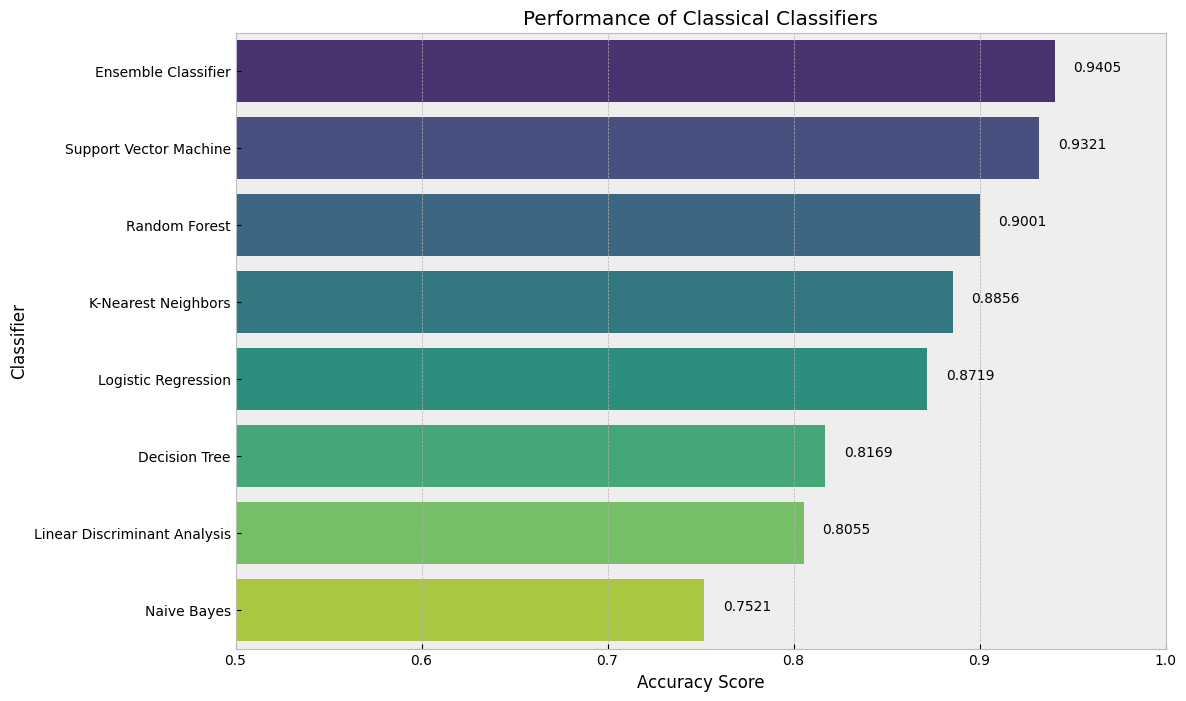

In [55]:
results_df = pd.DataFrame(list(results.items()), columns=['Classifier', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)

plt.style.use('bmh')
plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Classifier', data=results_df, palette='viridis')
plt.title('Performance of Classical Classifiers')
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier')
plt.xlim(0.5, 1.0)

for index, value in enumerate(results_df['Accuracy']):
    plt.text(value + 0.01, index, f"{value:.4f}")

plt.show()

## Deep Learning Classification

A Convolutional Neural Network (CNN) learns the most relevant features directly from the image pixels.

### Training and Evaluation

This function will handle the entire training and validation process for any PyTorch model we give it. It will loop through the data for a specified number of epochs, calculate loss, update the model's weights, and track our performance history.

In [16]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
                dataloader = train_loader
            else:
                model.eval()  
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloader, desc=f"{phase} phase"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, history

### Training-Validation Plot

We have a helper function to plot the training and validation accuracy/loss over time. This helps us diagnose issues like overfitting.

In [17]:
def plot_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history['train_acc'])
    ax1.plot(history['val_acc'])
    ax1.set_title('Model accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    ax2.plot(history['train_loss'])
    ax2.plot(history['val_loss'])
    ax2.set_title('Model loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

### Defining the CNN Architecture

The architecture consists of several convolutional layers to detect features, followed by ReLU activation functions, pooling layers to reduce dimensionality, and dropout layers to prevent overfitting.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

### Training the CNN

In [19]:
custom_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_model.parameters(), lr=LEARNING_RATE)

custom_model_trained, custom_history = train_model(
    custom_model, train_loader, val_loader, criterion, optimizer, num_epochs=NUM_EPOCHS
)

Epoch 1/30
----------


train phase: 100%|██████████| 152/152 [00:30<00:00,  4.95it/s]


train Loss: 0.8118 Acc: 0.6937


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.59it/s]


val Loss: 0.4624 Acc: 0.8203

Epoch 2/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.65it/s]


train Loss: 0.4760 Acc: 0.8159


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


val Loss: 0.3388 Acc: 0.8751

Epoch 3/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.64it/s]


train Loss: 0.3627 Acc: 0.8604


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.71it/s]


val Loss: 0.3122 Acc: 0.8763

Epoch 4/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.63it/s]


train Loss: 0.3039 Acc: 0.8939


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.65it/s]


val Loss: 0.2650 Acc: 0.9032

Epoch 5/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.64it/s]


train Loss: 0.2430 Acc: 0.9129


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.49it/s]


val Loss: 0.2110 Acc: 0.9312

Epoch 6/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


train Loss: 0.2158 Acc: 0.9172


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


val Loss: 0.1984 Acc: 0.9323

Epoch 7/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


train Loss: 0.1782 Acc: 0.9374


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.98it/s]


val Loss: 0.1734 Acc: 0.9417

Epoch 8/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.66it/s]


train Loss: 0.1463 Acc: 0.9458


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.62it/s]


val Loss: 0.1857 Acc: 0.9405

Epoch 9/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.66it/s]


train Loss: 0.1305 Acc: 0.9524


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.97it/s]


val Loss: 0.1714 Acc: 0.9510

Epoch 10/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.68it/s]


train Loss: 0.1236 Acc: 0.9594


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.57it/s]


val Loss: 0.1745 Acc: 0.9452

Epoch 11/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.66it/s]


train Loss: 0.1021 Acc: 0.9640


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.73it/s]


val Loss: 0.1542 Acc: 0.9498

Epoch 12/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.70it/s]


train Loss: 0.0951 Acc: 0.9710


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.94it/s]


val Loss: 0.1494 Acc: 0.9522

Epoch 13/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.64it/s]


train Loss: 0.0933 Acc: 0.9695


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.00it/s]


val Loss: 0.1235 Acc: 0.9638

Epoch 14/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.65it/s]


train Loss: 0.0709 Acc: 0.9759


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.68it/s]


val Loss: 0.1867 Acc: 0.9510

Epoch 15/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.67it/s]


train Loss: 0.0729 Acc: 0.9771


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.09it/s]


val Loss: 0.1483 Acc: 0.9627

Epoch 16/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.65it/s]


train Loss: 0.0591 Acc: 0.9817


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.52it/s]


val Loss: 0.1387 Acc: 0.9638

Epoch 17/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.62it/s]


train Loss: 0.0724 Acc: 0.9763


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.46it/s]


val Loss: 0.1424 Acc: 0.9650

Epoch 18/30
----------


train phase: 100%|██████████| 152/152 [00:33<00:00,  4.60it/s]


train Loss: 0.0630 Acc: 0.9802


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.46it/s]


val Loss: 0.1691 Acc: 0.9615

Epoch 19/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.70it/s]


train Loss: 0.0648 Acc: 0.9794


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.78it/s]


val Loss: 0.1275 Acc: 0.9708

Epoch 20/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.65it/s]


train Loss: 0.0510 Acc: 0.9854


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.20it/s]


val Loss: 0.1776 Acc: 0.9650

Epoch 21/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.72it/s]


train Loss: 0.0398 Acc: 0.9885


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.37it/s]


val Loss: 0.1453 Acc: 0.9650

Epoch 22/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.73it/s]


train Loss: 0.0386 Acc: 0.9907


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.25it/s]


val Loss: 0.1474 Acc: 0.9708

Epoch 23/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.72it/s]


train Loss: 0.0316 Acc: 0.9909


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.24it/s]


val Loss: 0.1589 Acc: 0.9615

Epoch 24/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.71it/s]


train Loss: 0.0395 Acc: 0.9868


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.29it/s]


val Loss: 0.1736 Acc: 0.9743

Epoch 25/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.72it/s]


train Loss: 0.0494 Acc: 0.9831


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


val Loss: 0.1626 Acc: 0.9720

Epoch 26/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.69it/s]


train Loss: 0.0421 Acc: 0.9846


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.90it/s]


val Loss: 0.1749 Acc: 0.9697

Epoch 27/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.71it/s]


train Loss: 0.0322 Acc: 0.9905


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.99it/s]


val Loss: 0.1763 Acc: 0.9685

Epoch 28/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.71it/s]


train Loss: 0.0336 Acc: 0.9895


val phase: 100%|██████████| 27/27 [00:03<00:00,  8.96it/s]


val Loss: 0.1826 Acc: 0.9720

Epoch 29/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.71it/s]


train Loss: 0.0492 Acc: 0.9854


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.47it/s]


val Loss: 0.1644 Acc: 0.9662

Epoch 30/30
----------


train phase: 100%|██████████| 152/152 [00:32<00:00,  4.71it/s]


train Loss: 0.0332 Acc: 0.9903


val phase: 100%|██████████| 27/27 [00:02<00:00,  9.05it/s]

val Loss: 0.1938 Acc: 0.9662

Training complete in 17m 45s
Best val Acc: 0.974329


### Visualizing the Results

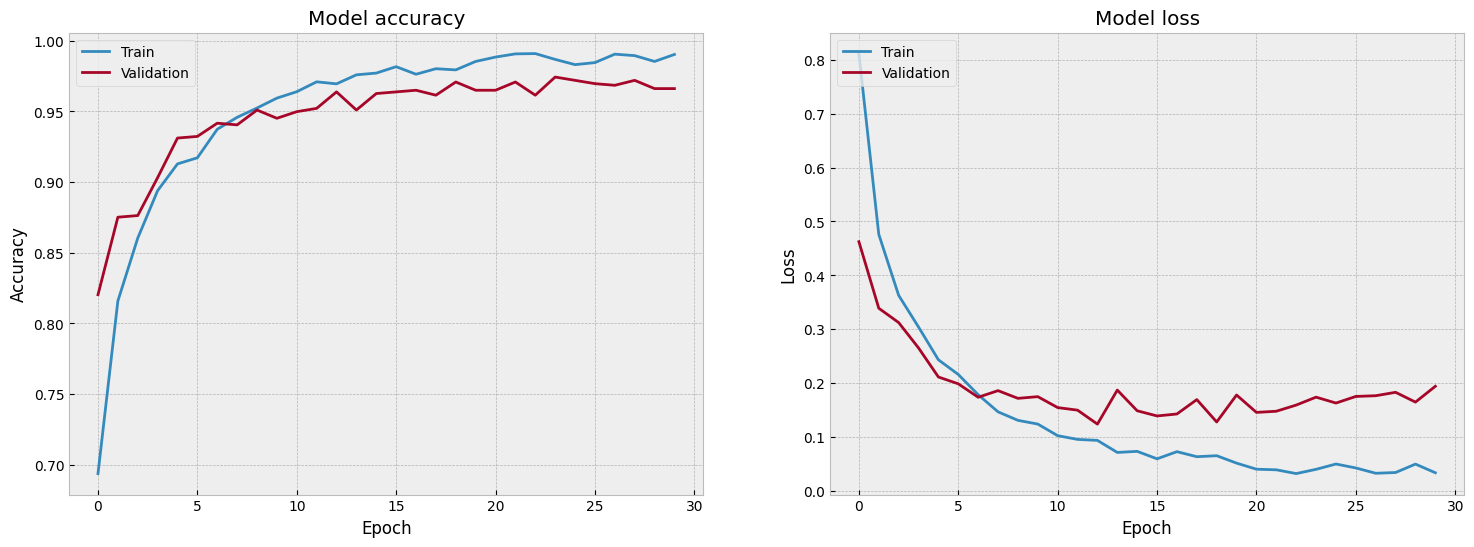

In [20]:
plot_history(custom_history)

In [ ]:
def get_predictions(model, dataloader):

    model.eval() 
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Getting Predictions"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds = torch.cat((all_preds, preds), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)
            
    return all_preds.cpu().numpy(), all_labels.cpu().numpy()

y_pred_cnn, y_true_cnn = get_predictions(custom_model_trained, test_loader)

Getting Predictions: 100%|██████████| 41/41 [00:03<00:00, 10.54it/s]


In [ ]:
class_names = [item[0] for item in sorted(global_label_map.items(), key=lambda item: item[1])]

cnn_report = classification_report(y_true_cnn, y_pred_cnn, target_names=class_names)
print("--- Classification Report for CNN ---\n")
print(cnn_report)

--- Classification Report for CNN ---

              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       300
  meningioma       0.95      0.96      0.95       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



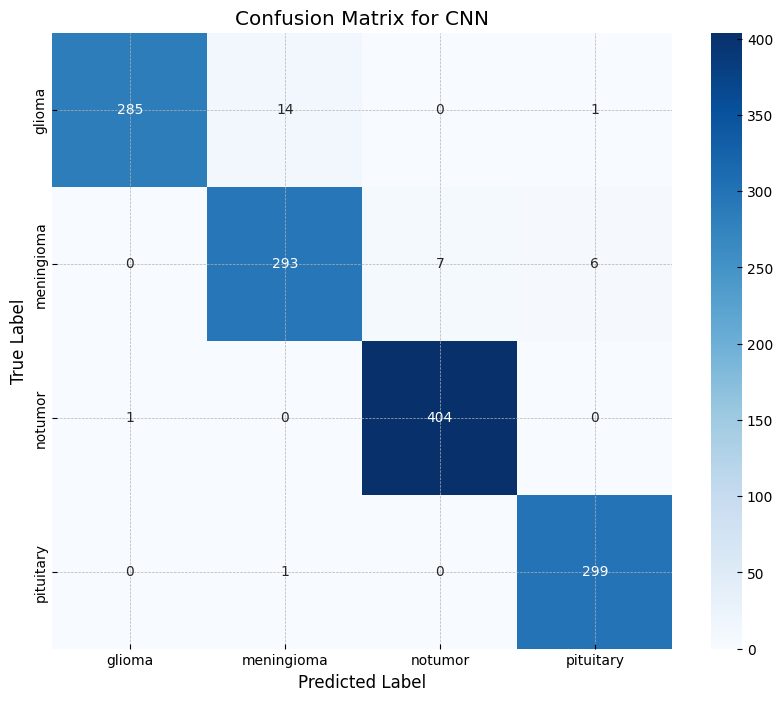

In [ ]:
cnn_cm = confusion_matrix(y_true_cnn, y_pred_cnn)

plt.figure(figsize=(10, 8))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

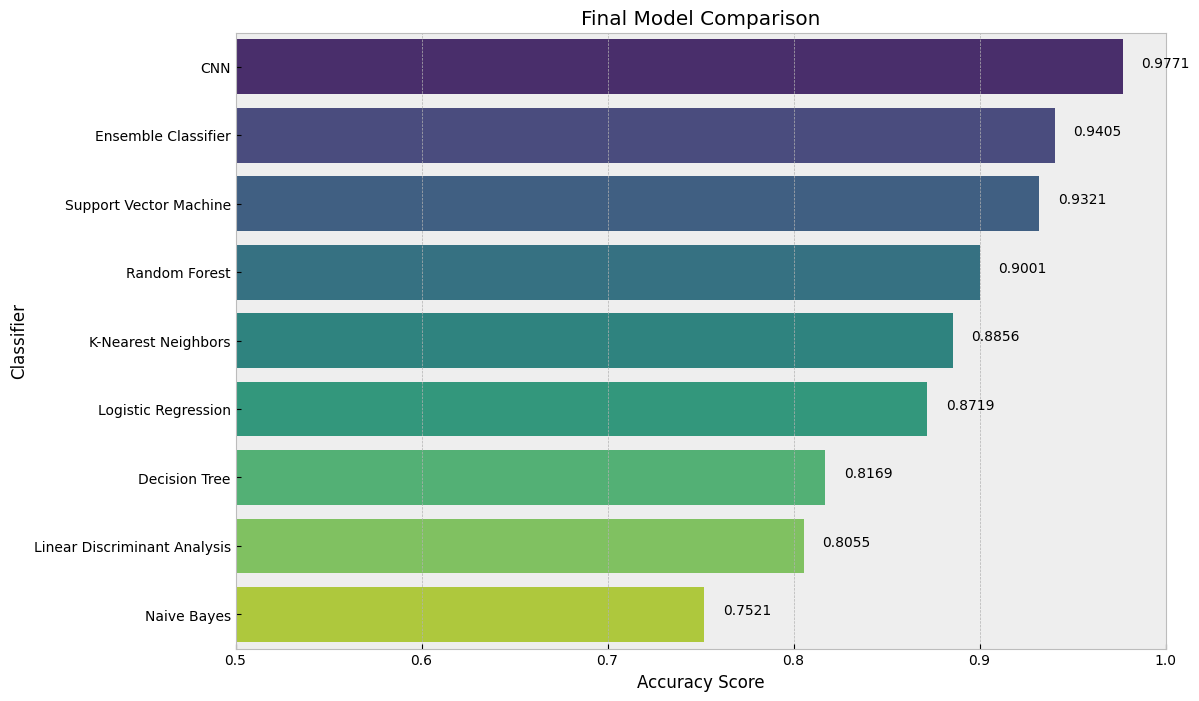

In [ ]:
from sklearn.metrics import accuracy_score

cnn_accuracy = accuracy_score(y_true_cnn, y_pred_cnn)

new_result = pd.DataFrame([{'Classifier': 'CNN', 'Accuracy': cnn_accuracy}])
final_results_df = pd.concat([results_df, new_result], ignore_index=True)
final_results_df = final_results_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Accuracy', y='Classifier', data=final_results_df, palette='viridis')
plt.title('Final Model Comparison')
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier')
plt.xlim(0.5, 1) 

for index, row in final_results_df.iterrows():
    plt.text(row['Accuracy'] + 0.01, index, f"{row['Accuracy']:.4f}")

plt.show()
